# Curvature-based Sampling:

With the ability to compute the Ricci scalar on arbitrary differentiable manifolds, we can draw random samples on the manifold correlated to the scalar curvature. We show this by employing the Metropolis-Hastings algorithm to generate samples in regions exhibiting higher-degrees of scalar curvature.

In [1]:
import typing as tp

import riemax as rx

import einops

import jax
import jax.numpy as jnp
import jax.tree_util as jtu

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

jax.config.update('jax_platform_name', 'cpu')

## Defining the Manifold:

In [2]:
key = jax.random.PRNGKey(42)

fn_transformation = rx.fn_transformations.fn_peaks
manifold = rx.Manifold.from_fn_transformation(fn_transformation)

## Metropolis-Hastings Sampling:

We will conduct Metropolis-Hastings sampling with 5 independant chains:

In [3]:
@jax.jit
def compute_curvature(x: jax.Array) -> jax.Array:
    return jnp.abs(manifold.ricci_scalar(x))

In [4]:
x_initial = jnp.array([0.0, 0.0])

pos, do_accept = jax.vmap(rx.numerical.sampling.rwmh_sampler, in_axes=(0, None, None, None))(
    jax.random.split(key, num=5),
    int(5e4),
    compute_curvature,
    x_initial,
)

accepted_pos = pos[do_accept]

## Visualisation

We generate a grid on which to visualise the manifold, and the Ricci scalar:

In [5]:
def generate_coordinate_grid(fn: tp.Callable[[jax.Array], jax.Array], n_points: int, limits: tuple[int, int]) -> jax.Array:
    
    d = jnp.linspace(*limits, n_points)
    coords = jnp.array([*jnp.meshgrid(d, d, indexing='ij')]).T
    
    flat_coords = einops.rearrange(coords, 'i j n -> (i j) n')    
    euc_coords = einops.rearrange(jax.vmap(fn)(flat_coords), '(i j) n -> i j n', i=n_points)
    
    return euc_coords

n_points = 1000
euc_coords = generate_coordinate_grid(fn_transformation, n_points=n_points, limits=[-3.0, 3.0])

r_field = jax.vmap(jax.vmap(manifold.ricci_scalar))(euc_coords[..., :2])

Finally, we plot the samples on the manifold:

(-3.0, 3.0)

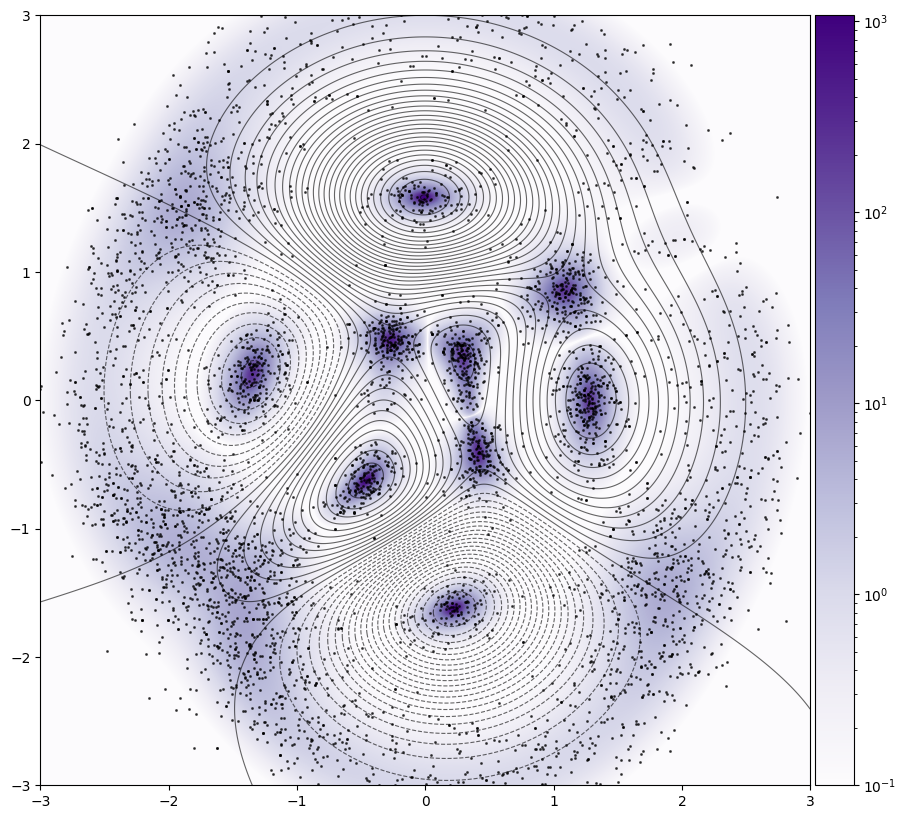

In [6]:
fig = plt.figure(figsize=(12, 10))
ax = fig.gca()

# plot shape of manifold
ax.contour(*euc_coords.T, levels=50, alpha=0.6, colors='k', linewidths=0.8)

# plot colourmap of ricci scalar
im = ax.imshow(jnp.abs(r_field), cmap=cm.Purples, extent=(-3, 3, -3, 3), origin='lower', alpha=1.0, norm=colors.LogNorm(1e-1, vmax=r_field.max()))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax)

# plot random samples
_samples = jax.random.choice(key, accepted_pos, shape=(5000,))
ax.scatter(*_samples.T, c='k', marker='.', s=5, alpha=0.6)

# configure plot
ax.set_aspect('equal')

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)